In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

In [5]:
f = open('metadata.json')
data = json.load(f)

#to extract upright rect coordinates for each image

data_prepr={}
for pool in data:
    x_list = []
    y_list = []
    for bounds in data[pool]['bounds_x_y']:
        x_list = x_list + [bounds['x']]
        y_list = y_list + [bounds['y']]
    geom = list(zip(x_list, y_list))
    data_prepr[pool] = {'rect': tuple(int(d/4) for d in cv2.boundingRect(np.array([list(x) for x in (np.array(geom))], np.float32))), 'polyg': data[pool]['bounds_x_y']}

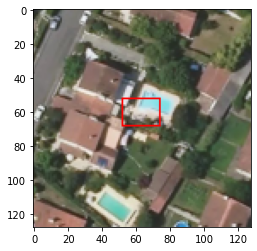

In [6]:
#plotting bounding box
img_name='43.7362082_1.4762406.png'
img = cv2.imread('images/'+img_name)
img=cv2.resize(img,(128,128))
# plt.imshow(img)

x,y,w,h = data_prepr[img_name]['rect']
bnd_img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),1)
plt.imshow(bnd_img[:,:,::-1])

In [7]:
def load_img(path) :
    X = []
    for i in sorted(glob.glob(path)) :
        img_path = i
        img = image.load_img(img_path, target_size=(128, 128))
        x = image.img_to_array(img)
        # x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X.append(x)
    return np.asarray(X)

In [ ]:
#loading X variables
X = load_img('images/*.png')
X.shape

In [ ]:
#sorted list of images by name
image_name_list = [x.split("/")[1] for x in sorted(glob.glob("images/*.png"))]

In [ ]:
#loading dependent variables
coord_list=[]
for im in image_name_list:
    x,y,w,h = data_prepr[im]['rect']
    coord_list.append([x,y,x+w,y+h])
Y=np.asarray(coord_list)
Y=np.append(Y,[[x] for x in image_name_list],axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

In [ ]:
img_train = y_train[:,-1]
y_train = y_train[:,:-1].astype(float)

img_test = y_test[:,-1]
y_test = y_test[:,:-1].astype(float)

In [ ]:
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model1.trainable = False

chopped_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[90].output])

localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)

model1 = Model(inputs=[chopped_resnet1.input], outputs=localization_output1)
model1.summary()

In [ ]:
model1.compile(optimizer='adam', metrics=['accuracy'],loss=['mse'])
#lets run it through 10 epochs
history2=model1.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10,verbose=True,batch_size=500)
history2

In [ ]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
plot_training_history(history2, model1)

In [19]:
model1.save('my_model_pretrained.h5')

In [20]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model_pretrained.h5')

# Show the model architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [21]:
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2022-05-12 11:06:18.054912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 - 8s - loss: 4.7138 - accuracy: 0.9145 - 8s/epoch - 88ms/step
Restored model, accuracy: 91.45%


In [22]:
y_predict =new_model.predict(X_test)

2022-05-12 11:06:43.151941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43.5571215_1.3153265.png
43.7120842_1.5122267.png
43.0858586_1.6478752.png
43.735839_1.4691417.png
43.5708432_1.2949917.png


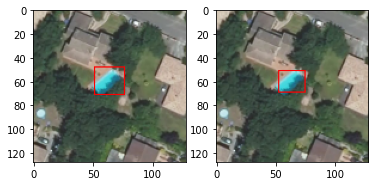

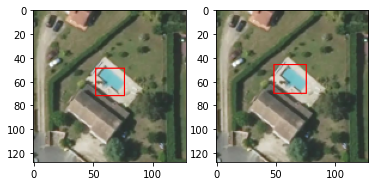

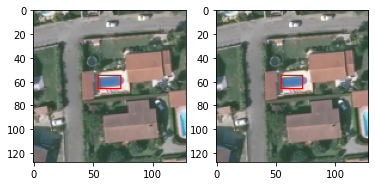

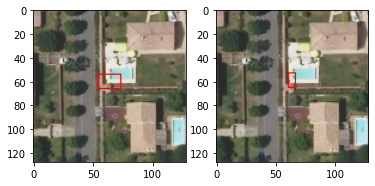

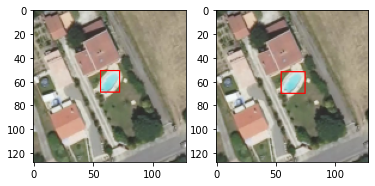

In [24]:
#plotting bounding box for predictions
for i in random.sample(range(0, len(y_predict)-1), 5):
    img_name=img_test[i]
    img = cv2.imread('images/'+img_name,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))

    x,y,w,h = data_prepr[img_name]['rect']
    bnd_img=cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),1)
    #plt.imshow(bnd_img[:,:,::-1])

    #plotting bounding box for predictions
    img2 = cv2.imread('images/'+img_name,cv2.COLOR_BGR2RGB)
    img2=cv2.resize(img2,(128,128))

    img_index = np.where(img_test==img_name)[0][0] 
    coords = y_predict[img_index].astype(int)
   # print(coords)

    bnd_img2=cv2.rectangle(img2,(coords[0],coords[1]),(coords[2],coords[3]),(0,0,255),1)
    #plt.imshow(bnd_img2[:,:,::-1])
    
    print(img_name)
    f,subplots = plt.subplots(1,2)
    subplots[0].imshow(bnd_img[:,:,::-1])
    subplots[1].imshow(bnd_img2[:,:,::-1])

In [25]:
def iou2(bounding_box, compare_box):
 
    
    #FOR FINDING INTERSECTION OVER UNION
    xA = max(bounding_box[0], compare_box[0])
    yA = max(bounding_box[1], compare_box[1])
    xB = min(bounding_box[2], compare_box[2])
    yB = max(bounding_box[3], compare_box[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (bounding_box[2] - bounding_box[0] + 1) * (bounding_box[3] - bounding_box[1] + 1)
    boxBArea = (compare_box[2] - compare_box[0] + 1) * (compare_box[3] - compare_box[1] + 1)
    iou =interArea/float(boxAArea+boxBArea-interArea)
    return iou

In [26]:
iou_list=[]
for y_ind in range(y_predict.shape[0]-1):
    iou_list.append(iou2(y_predict[y_ind],y_test[y_ind]))
print("Average Intersection over Union is",np.mean(iou_list))

Average Intersection over Union is 0.8612405761627716


In [50]:
#different iou calc

# def iou(box1, box2):
#         x1, y1, x2, y2 = box1
#         x3, y3, x4, y4 = box2
#         x_inter1 = max(x1, x3)
#         y_inter1 = max(y1, y3)
#         x_inter2 = min(x2, x4)
#         y_inter2 = min(y2, y4)
#         width_inter = abs(x_inter2 - x_inter1)
#         height_inter = abs(y_inter2 - y_inter1)
#         area_inter = width_inter * height_inter
#         width_box1 = abs(x2 - x1)
#         height_box1 = abs(y2 - y1)
#         width_box2 = abs(x4 - x3)
#         height_box2 = abs(y4 - y3)
#         area_box1 = width_box1 * height_box1
#         area_box2 = width_box2 * height_box2
#         area_union = area_box1 + area_box2 - area_inter
#         iou = area_inter / area_union
#         return iou